In [20]:
from pandas import read_csv, unique
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,LSTM, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv('C:/WISDM.csv', index_col=0)
df = df.drop(['user-id', 'timestamp'], axis=1)

Jogging = df[df['activity']=='Jogging'].head(4500)
Sitting = df[df['activity']=='Sitting'].head(4499)
Sitting['activity']=0
Jogging['activity']=1
new_df = pd.concat([Sitting,Jogging]).sample(frac=1).reset_index(drop=True)
new_df


,activity,X,Y,Z
0,0,3.2600000,9.1900000,1.1441092
1,0,3.3400000,9.2800000,1.1441092
2,0,-4.9900000,-2.2600000,7.8180795
3,0,-4.2500000,-2.2600000,8.1994500
4,1,-1.3756552,5.7886477,5.2165933
...,...,...,...,...
8994,0,3.1100000,9.3000000,1.2258313
8995,1,-8.5399580,19.5724400,4.5628166
8996,1,5.0122880,10.9507600,2.6832085
8997,0,-4.2900000,-2.2200000,8.3492730


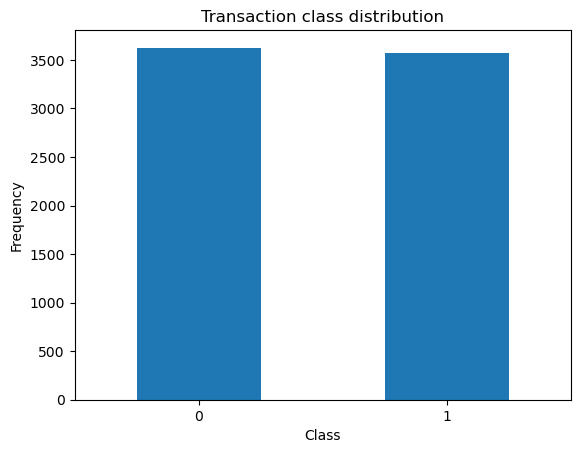

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(new_df, test_size=0.2, random_state=42)

count_classes = pd.value_counts(X_train['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency");


In [23]:
X_train = X_train[X_train.activity == 0]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape, X_test.shape, y_test.shape

((3625, 3), (1800, 3), (1800,))

In [38]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
NUM_COL = 3
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 32
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [40]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(12, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('relu'))
    
    
    generator.add(Dense(32))
    generator.add(Activation('relu'))
    
    generator.add(Dense(64))
    generator.add(Activation('relu'))
       
    generator.add(Dense(128))
    generator.add(Activation('relu'))
   
    generator.add(Dense(NUM_COL, activation='relu'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [41]:
#### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(128, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))

    discriminator.add(Dense(64))
    discriminator.add(Activation('relu'))
       
    discriminator.add(Dense(32))
    discriminator.add(Activation('relu'))   
    
    discriminator.add(Dense(12))
    discriminator.add(Activation('relu'))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [42]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    return gan

In [43]:
#Training the GAN
from keras import initializers
from tqdm import tqdm
#Calculating the number of batches based on the batch size
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))              

 21%|████████████████▌                                                               | 117/565 [00:12<00:26, 17.16it/s]

Epoch 0 Batch 112/113 [D loss: 0.518994] [G loss:1.191668]


 40%|████████████████████████████████▎                                               | 228/565 [00:18<00:21, 15.65it/s]

Epoch 1 Batch 112/113 [D loss: 0.516308] [G loss:1.009778]


 60%|████████████████████████████████████████████████▎                               | 341/565 [00:24<00:10, 20.61it/s]

Epoch 2 Batch 112/113 [D loss: 0.459932] [G loss:0.852020]


 81%|████████████████████████████████████████████████████████████████▍               | 455/565 [00:30<00:05, 20.02it/s]

Epoch 3 Batch 112/113 [D loss: 0.362369] [G loss:0.893718]


100%|███████████████████████████████████████████████████████████████████████████████▊| 564/565 [00:36<00:00, 19.78it/s]

Epoch 4 Batch 112/113 [D loss: 0.252408] [G loss:1.519661]


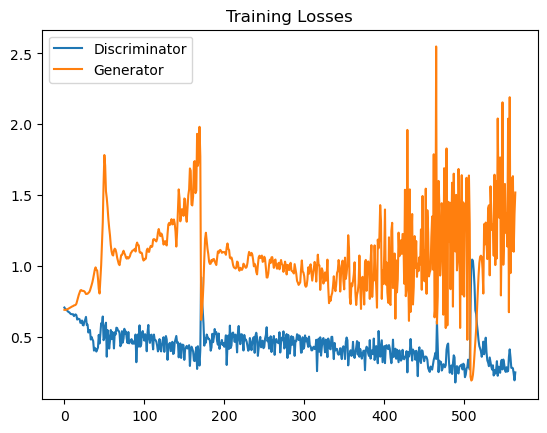

In [44]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [45]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [46]:
y_pred = results.copy()
y_pred

array([0.99994266, 0.65722853, 0.99961007, ..., 0.99915105, 0.65244496,
       0.98431671])

In [47]:
y2 = y_test.to_numpy()
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 0.8186783802216969
Mean score for Fall data : 0.7709504759420792


In [48]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [49]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.4955555555555556
Precision : 1.0
Recall : 0.019438444924406047
F1 : 0.038135593220338986


Confusion Matrix :


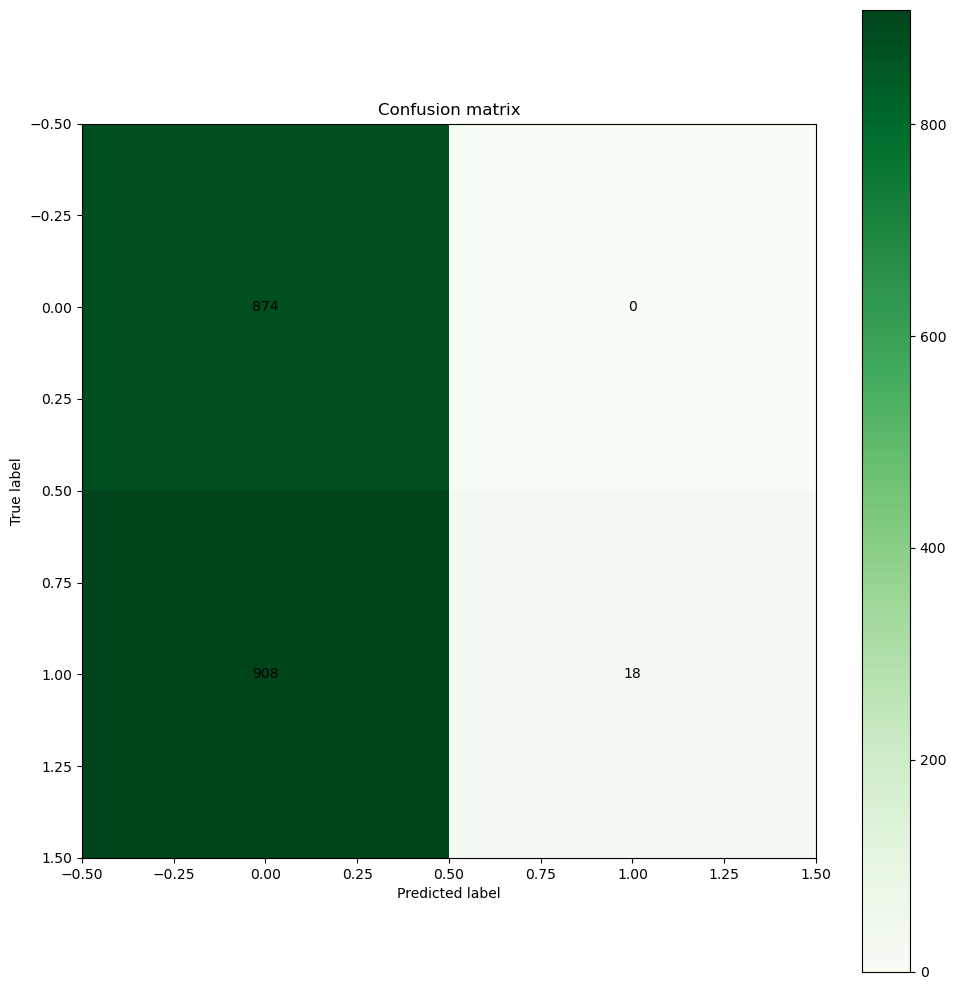

In [50]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

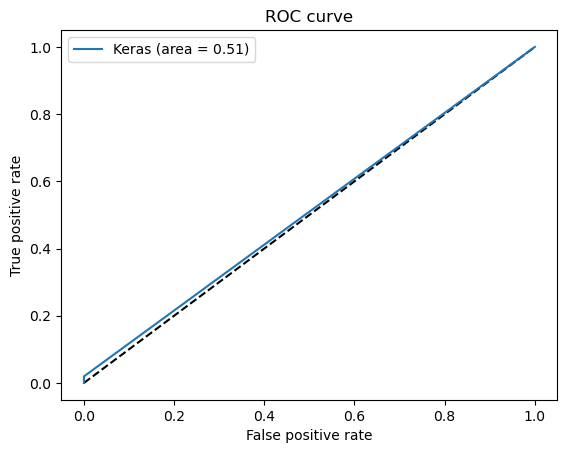

100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:47<00:00, 19.78it/s]

In [51]:
from sklearn.metrics import roc_curve,auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()